# Weights and Connections

When we have multiple groups of neurons, we then would want to *connect* them. This is done by assigning *weights* to the connections between the neurons, with the weights being the strength of the connection. For example, a weight of `0` would mean no connection, while a weight of `1` would mean a strong connection.

We can *learn* connection weights in a variety of ways, as we will go into later. 

For now, we will initialize them randomly using [`np.random.randn()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html). This will give us a random number from a normal distribution with a mean of `0` and a standard deviation of `1`.:

In [1]:
import numpy as np

np.random.seed(1) # Set random seed for reproducibility

class LIFCollection:
    def __init__(self, n=1, dim=1, tau_rc=0.02, tau_ref=0.002, v_th=1, 
                 max_rates=[200, 400], intercept_range=[-1, 1], t_step=0.001, v_init = 0):
        self.n = n
        # Set neuron parameters
        self.dim = dim  # Dimensionality of the input
        self.tau_rc = tau_rc  # Membrane time constant
        self.tau_ref = tau_ref  # Refractory period
        self.v_th = np.ones(n) * v_th  # Threshold voltage for spiking
        self.t_step = t_step  # Time step for simulation
        
        # Initialize state variables
        self.voltage = np.ones(n) * v_init  # Initial voltage of neurons
        self.refractory_time = np.zeros(n)  # Time remaining in refractory period
        self.output = np.zeros(n)  # Output spikes

        # Generate random max rates and intercepts within the given range
        max_rates_tensor = np.random.uniform(max_rates[0], max_rates[1], n)
        intercepts_tensor = np.random.uniform(intercept_range[0], intercept_range[1], n)

        # Calculate gain and bias for each neuron
        self.gain = self.v_th * (1 - 1 / (1 - np.exp((self.tau_ref - 1/max_rates_tensor) / self.tau_rc))) / (intercepts_tensor - 1)
        self.bias = np.expand_dims(self.v_th - self.gain * intercepts_tensor, axis=1)
        
        # Initialize random encoders
        self.encoders = np.random.randn(n, self.dim)
        self.encoders /= np.linalg.norm(self.encoders, axis=1)[:, np.newaxis]

    def reset(self):
        # Reset the state variables to initial conditions
        self.voltage = np.zeros(self.n)
        self.refractory_time = np.zeros(self.n)
        self.output = np.zeros(self.n)

    def step(self, inputs):
        dt = self.t_step  # Time step

        # Update refractory time
        self.refractory_time -= dt
        delta_t = np.clip(dt - self.refractory_time, 0, dt) # ensure between 0 and dt

        # Calculate input current
        I = np.sum(self.bias + inputs * self.encoders * self.gain[:, np.newaxis], axis=1)

        # Update membrane potential
        self.voltage = I + (self.voltage - I) * np.exp(-delta_t / self.tau_rc)

        # Determine which neurons spike
        spike_mask = self.voltage > self.v_th
        self.output[:] = spike_mask / dt  # Record spikes in output

        # Calculate the time of the spike
        t_spike = self.tau_rc * np.log((self.voltage[spike_mask] - I[spike_mask]) / (self.v_th[spike_mask] - I[spike_mask])) + dt

        # Reset voltage of spiking neurons
        self.voltage[spike_mask] = 0

        # Set refractory time for spiking neurons
        self.refractory_time[spike_mask] = self.tau_ref + t_spike

        return self.output  # Return the output spikes
    
class SynapseCollection:
    def __init__(self, n=1, tau_s=0.05, t_step=0.001):
        self.n = n
        self.a = np.exp(-t_step / tau_s)  # Decay factor for synaptic current
        self.b = 1 - self.a  # Scale factor for input current

        self.voltage = np.zeros(n)  # Initial voltage of neurons
    
    def step(self, inputs):
        self.voltage = self.a * self.voltage + self.b * inputs

        return self.voltage

In [2]:
t_step = 0.001

neurons_a = LIFCollection(n=50, tau_rc=0.02, tau_ref=0.002, t_step=t_step)
synapses_a = SynapseCollection(n=neurons_a.n, tau_s=0.1, t_step=t_step)
neurons_b = LIFCollection(n=40, tau_rc=0.02, tau_ref=0.002, t_step=t_step)
synapses_b = SynapseCollection(n=neurons_b.n, tau_s=0.1, t_step=t_step)

weights = np.random.randn(neurons_a.n, neurons_b.n)

outp = []
def step(inp):
    a  = neurons_a.step(inp)
    b  = synapses_a.step(a)
    bw = b @ weights
    c  = neurons_b.step(bw)
    d  = synapses_b.step(c)
    return (a, b, bw, c, d)

T = 10

times = np.arange(0, T, t_step)
def inp(t):
    return np.sin(t)

for t in times:
    outp.append(step(inp(t)))

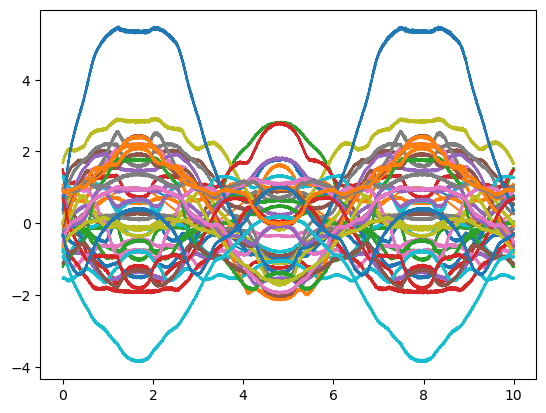

In [3]:


def func(x):
    return x**2

# decoder_a = getDecoders(neurons_a, func=func) 
# decoder_b = getDecoders(neurons_b)

# # decoder_a = decoder_A
# # print(decoder_a.shape)
# # print(neurons_b.encoders.shape)


# weights = decoder_a @ [neurons_b.encoders.flatten()]
# # weights = np.random.randn(neurons_a.n, neurons_b.n)
# # print(decoder_a.shape)

outp = []

def step(inp):
    a  = neurons_a.step(inp)
    b  = synapses_a.step(a)
    bw = b @ weights
    c  = neurons_b.step(bw)
    d  = synapses_b.step(c)
    outp.append((a, b, bw, c, d, inp))
    return d


T = 10

times = np.arange(0, T, t_step)
def inp(t):
    return np.sin(t)

for t in times:
    step(inp(t))


import matplotlib.pyplot as plt

a_out = list(map(lambda x: x[0], outp))
b_out = list(map(lambda x: x[1], outp))
bw_out = list(map(lambda x: x[2], outp))
c_out = list(map(lambda x: x[3], outp))
d_out = list(map(lambda x: x[4], outp))
inps = list(map(lambda x: x[5], outp))


plt.plot(times, inps)
plt.plot(times, [func(i) for i in inps])
# plt.plot(times, b_out @ decoder_a)
# plt.plot(times, d_out @ decoder_B)
# plt.plot(times, a_out)
plt.plot(times, [b * t_step for b in bw_out])
# plt.plot(times, bw_out)
# plt.plot(times, c_out)
# plt.plot(times, d_out)
plt.show()

In [4]:
%matplotlib inline

import math
import random

import numpy
import matplotlib.pyplot as plt

dt = 0.001  # simulation time step
t_rc = 0.02  # membrane RC time constant
t_ref = 0.002  # refractory period
t_pstc = 0.1  # post-synaptic time constant
N_A = 50  # number of neurons in first population
N_B = 40  # number of neurons in second population
N_samples = 100  # number of sample points to use when finding decoders
rate_A = 25, 75  # range of maximum firing rates for population A
rate_B = 50, 100  # range of maximum firing rates for population B


def input(t):
    """The input to the system over time"""
    return math.sin(t)


def function(x):
    """The function to compute between A and B."""
    return x * x


# create random encoders for the two populations
# encoder_A = [random.choice([-1, 1]) for _ in range(N_A)]
# encoder_B = [random.choice([-1, 1]) for _ in range(N_B)]


def generate_gain_and_bias(count, intercept_low, intercept_high, rate_low, rate_high):
    gain = []
    bias = []
    for _ in range(count):
        # desired intercept (x value for which the neuron starts firing
        intercept = random.uniform(intercept_low, intercept_high)
        # desired maximum rate (firing rate when x is maximum)
        rate = random.uniform(rate_low, rate_high)

        # this algorithm is specific to LIF neurons, but should
        # generate gain and bias values to produce the desired
        # intercept and rate
        z = 1.0 / (1 - math.exp((t_ref - (1.0 / rate)) / t_rc))
        g = (1 - z) / (intercept - 1.0)
        b = 1 - g * intercept
        gain.append(g)
        bias.append(b)
    return gain, bias


# random gain and bias for the two populations
# gain_A, bias_A = generate_gain_and_bias(N_A, -1, 1, rate_A[0], rate_A[1])
# gain_B, bias_B = generate_gain_and_bias(N_B, -1, 1, rate_B[0], rate_B[1])
gain_A = neurons_a.gain
bias_A = neurons_a.bias.flatten()
encoder_A = neurons_a.encoders.flatten()

gain_B = neurons_b.gain
bias_B = neurons_b.bias.flatten()
encoder_B = neurons_b.encoders.flatten()

In [5]:
import numpy as np

def runNeurons1(inp, neurons, T=1, dt=0.001):
    times = np.arange(0, T, dt)
    outp = []
    for t in times:
        a  = neurons.step(inp) * dt
        outp.append(a)
    spike_counts = np.sum(outp, axis=0)
    return spike_counts / T

def getTuningCurves1e(neurons, inputs):
    result = []
    for i in inputs:
        neurons.reset()
        result.append(runNeurons1(i, neurons))
    neurons.reset()
    return result

def getTuningCurves1a(neurons, I):
    def analyticalRate(v_th, tau_ref, tau_rc, I):
        if I <= v_th: return 0
        else:         return 1 / (tau_ref - tau_rc * np.log(1 - v_th/I))
    tuningCurves = np.vectorize(analyticalRate)(neurons.v_th[-1], neurons.tau_ref, neurons.tau_rc, I)
    return tuningCurves

def getDecoders1(neurons, minJ=-1, maxJ=1, stepSize=0.01, func=lambda x: x):
    def analyticalRate(v_th, tau_ref, tau_rc, I):
        if I <= v_th: return 0
        else:         return 1 / (tau_ref - tau_rc * np.log(1 - v_th/I))

    inputs = np.arange(minJ, maxJ, stepSize)

    gain_matrix = np.tile(neurons.gain[:, np.newaxis], (1, len(inputs)))
    bias_matrix = np.tile(neurons.bias, (1, len(inputs)))
    encoders_matrix = np.tile(neurons.encoders, (1, len(inputs)))

    I = inputs * gain_matrix * encoders_matrix + bias_matrix

    tuningCurves = np.vectorize(analyticalRate)(neurons.v_th[-1], neurons.tau_ref, neurons.tau_rc, I)

    A = np.array(tuningCurves)

    value = np.expand_dims(list(map(func, inputs)), axis=1)

    Gamma = A @ A.T + np.identity(len(neurons.output))
    GammaInv = np.linalg.inv(Gamma)
    Upsilon = A @ value

    Phi = GammaInv @ Upsilon

    return Phi

inputs = np.arange(-1, 1, 0.01)
gain_matrix = np.tile(neurons_a.gain[:, np.newaxis], (1, len(inputs)))
bias_matrix = np.tile(neurons_a.bias, (1, len(inputs)))
encoders_matrix = np.tile(neurons_a.encoders, (1, len(inputs)))

I = inputs * gain_matrix * encoders_matrix + bias_matrix
print(np.array(getTuningCurves1e(neurons_a, I)))
print(np.array(getTuningCurves1a(neurons_a, I)))
# tca = np.array(g)

[[500.   0.   0. ...   0. 500. 500.]
 [  0. 500. 500. ... 500.   0.   0.]
 [500.   0.   0. ...   0. 499. 500.]
 ...
 [491. 499. 496. ... 497. 490.   0.]
 [500.   0.   0. ...   0. 500. 500.]
 [  0. 500. 498. ... 499.   0.   0.]]
[[  0   0   0 ... 281 282 282]
 [344 342 340 ...   0   0   0]
 [200 199 198 ...   0   0   0]
 ...
 [258 257 255 ...   0   0   0]
 [  0  12  17 ... 255 256 256]
 [  0   0   0 ... 221 222 224]]


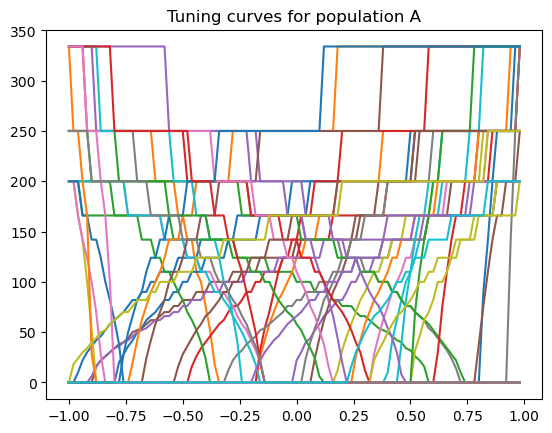

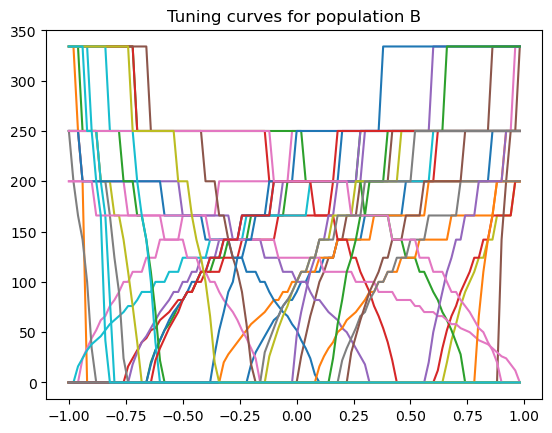

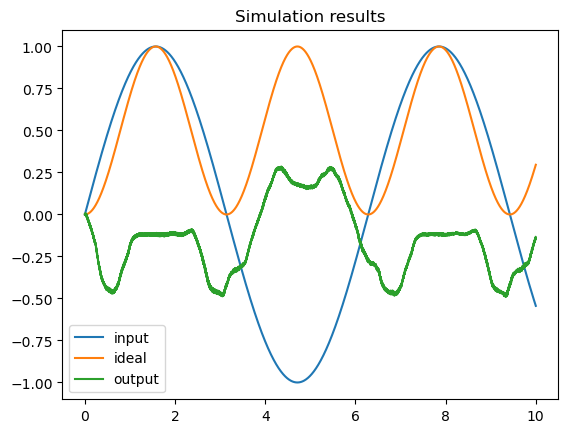

In [6]:

def run_neurons(input, v, ref):
    """Run the neuron model.

    A simple leaky integrate-and-fire model, scaled so that v=0 is resting
    voltage and v=1 is the firing threshold.
    """
    spikes = []
    for i, vi in enumerate(v):
        dV = dt * (input[i] - vi) / t_rc  # the LIF voltage change equation
        v[i] += dV
        if v[i] < 0:
            v[i] = 0  # don't allow voltage to go below 0

        if ref[i] > 0:  # if we are in our refractory period
            v[i] = 0  # keep voltage at zero and
            ref[i] -= dt  # decrease the refractory period

        if v[i] > 1:  # if we have hit threshold
            spikes.append(True)  # spike
            v[i] = 0  # reset the voltage
            ref[i] = t_ref  # and set the refractory period
        else:
            spikes.append(False)
    return spikes


def compute_response(x, encoder, gain, bias, time_limit=0.5):
    """Measure the spike rate of a population for a given value x."""
    N = len(encoder)  # number of neurons
    v = [0] * N  # voltage
    ref = [0] * N  # refractory period

    # compute input corresponding to x
    input = []
    for i in range(N):
        input.append(x * encoder[i] * gain[i] + bias[i])
        v[i] = 0#random.uniform(0, 1)  # randomize the initial voltage level

    count = [0] * N  # spike count for each neuron

    # feed the input into the population for a given amount of time
    t = 0
    while t < time_limit:
        spikes = run_neurons(input, v, ref)
        for i, s in enumerate(spikes):
            if s:
                count[i] += 1
        t += dt
    return [c / time_limit for c in count]  # return the spike rate (in Hz)


def compute_tuning_curves(encoder, gain, bias):
    """Compute the tuning curves for a population"""
    def analyticalRate(v_th, tau_ref, tau_rc, I):
        if I <= v_th: return 0
        else:         return 1 / (tau_ref - tau_rc * np.log(1 - v_th/I))
    # generate a set of x values to sample at
    x_values = [i * 2.0 / N_samples - 1.0 for i in range(N_samples)]

    # build up a matrix of neural responses to each input (i.e. tuning curves)
    A = []
    for x in x_values:
        response = compute_response(x, encoder, gain, bias)
        # print(response)
        response2 =  [analyticalRate(1, t_ref, t_rc, x * g* e+ b) for g, e, b in zip(gain, encoder, bias)]
        # # print(response)
        diffs = [r1 - r2 for r1, r2 in zip(response, response2)]
        response2 = [r + d/16 for (r, d) in zip(response2, diffs)]
        # # print(diffs)
        # response = response2

        A.append(response)
    return x_values, A


def compute_decoder(encoder, gain, bias, function=lambda x: x):
    # get the tuning curves
    x_values, A = compute_tuning_curves(encoder, gain, bias)

    # get the desired decoded value for each sample point
    value = numpy.array([[function(x)] for x in x_values])

    # find the optimal linear decoder
    A = numpy.array(A).T
    Gamma = numpy.dot(A, A.T)
    Upsilon = numpy.dot(A, value)
    Ginv = numpy.linalg.pinv(Gamma)
    decoder = numpy.dot(Ginv, Upsilon) / dt
    return decoder


# find the decoders for A and B
decoder_A = compute_decoder(encoder_A, gain_A, bias_A, function=function)
decoder_B = compute_decoder(encoder_B, gain_B, bias_B)
# print(decoder_A)

# compute the weight matrix
# weights = decoder_A @ [encoder_B]
# print(weights)
# numpy.dot(decoder_A, [encoder_B])

v_A = [0.0] * N_A  # voltage for population A
ref_A = [0.0] * N_A  # refractory period for population A
input_A = [0.0] * N_A  # input for population A

v_B = [0.0] * N_B  # voltage for population B
ref_B = [0.0] * N_B  # refractory period for population B
input_B = [0.0] * N_B  # input for population B

# scaling factor for the post-synaptic filter
pstc_scale = 1.0 - math.exp(-dt / t_pstc)

# for storing simulation data to plot afterward
inputs = []
times = []
outputs = []
ideal = []

output = 0.0  # the decoded output value from population B
t = 0
while t < 10.0:  # noqa: C901 (tell static checker to ignore complexity)
    # call the input function to determine the input value
    x = input(t)

    # convert the input value into an input for each neuron
    for i in range(N_A):
        input_A[i] = x * encoder_A[i] * gain_A[i] + bias_A[i]

    # run population A and determine which neurons spike
    spikes_A = run_neurons(input_A, v_A, ref_A)

    # decay all of the inputs (implementing the post-synaptic filter)
    for j in range(N_B):
        input_B[j] *= 1.0 - pstc_scale
    # for each neuron that spikes, increase the input current
    # of all the neurons it is connected to by the synaptic
    # connection weight
    for i, s in enumerate(spikes_A):
        if s:
            for j in range(N_B):
                input_B[j] += weights[i][j] * pstc_scale

    # compute the total input into each neuron in population B
    # (taking into account gain and bias)
    total_B = [0] * N_B
    for j in range(N_B):
        total_B[j] = gain_B[j] * input_B[j] + bias_B[j]

    # run population B and determine which neurons spike
    spikes_B = run_neurons(total_B, v_B, ref_B)

    # for each neuron in B that spikes, update our decoded value
    # (also applying the same post-synaptic filter)
    output *= 1.0 - pstc_scale
    for j, s in enumerate(spikes_B):
        if s:
            output += decoder_B[j][0] * pstc_scale

    # if t % 0.5 <= dt:
    #     print(t, output)
    times.append(t)
    inputs.append(x)
    outputs.append(output)
    ideal.append(function(x))
    t += dt

x, A = compute_tuning_curves(encoder_A, gain_A, bias_A)
x, B = compute_tuning_curves(encoder_B, gain_B, bias_B)

plt.figure()
plt.plot(x, A)
plt.title("Tuning curves for population A")

plt.figure()
plt.plot(x, B)
plt.title("Tuning curves for population B")

plt.figure()
plt.plot(times, inputs, label="input")
plt.plot(times, ideal, label="ideal")
plt.plot(times, outputs, label="output")
plt.title("Simulation results")
plt.legend()
plt.show()
